# Covid Cases Dataset
_____

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

#import plotly.figure_factory as ft 

ImportError: dlopen(/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: /Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-39-darwin.so
  Reason: tried: '/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/lib/liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/bin/../lib/liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/lib/liblapack.3.dylib' (no such file), '/Users/silviaresende/miniforge3/envs/tensorflow/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)

In [ ]:
df_cases = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df_cases = df_cases[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
df_cases.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
0,01/25/2020,OR,0,0,0,0
1,09/17/2021,MD,"516,784","1,525","10,282",11
2,10/12/2021,VT,"33,388",112,333,4
3,02/01/2021,DC,"37,008",136,916,3
4,12/19/2021,NC,"1,586,243","3,410","19,480",19


In [ ]:
df_cases['submission_date'] = pd.to_datetime(df_cases['submission_date'])

In [ ]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59640 entries, 0 to 59639
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   submission_date  59640 non-null  datetime64[ns]
 1   state            59640 non-null  object        
 2   tot_cases        59640 non-null  object        
 3   new_case         59640 non-null  object        
 4   tot_death        59640 non-null  object        
 5   new_death        59640 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.7+ MB


In [ ]:
df_cases.set_index('submission_date', inplace=True)
df_cases.sort_index(inplace=True)

In [ ]:
df_cases.columns

Index(['state', 'tot_cases', 'new_case', 'tot_death', 'new_death'], dtype='object')

In [ ]:
df_cases['tot_cases'].value_counts()

0            4117
4             578
1             280
3             195
2             161
             ... 
401,591         1
526,423         1
815,593         1
621,542         1
7,135,916       1
Name: tot_cases, Length: 42844, dtype: int64

In [ ]:
df_cases['new_case'].value_counts()

0         14040
1           346
2           277
3           185
4           167
          ...  
13,181        1
10,421        1
21,940        1
16,373        1
5,470         1
Name: new_case, Length: 8121, dtype: int64

In [ ]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    df_cases[c] = df_cases[c].map( lambda x: x.replace(',','')).astype(int)
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [ ]:
df_cases[df_cases['tot_cases']==0].count()

state        4117
tot_cases    4117
new_case     4117
tot_death    4117
new_death    4117
dtype: int64

In [ ]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


In [ ]:
#df_cases.drop(df_cases[df_cases['tot_cases']==0].index, inplace=True)

In [ ]:
df_cases.shape

(59640, 5)

In [ ]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


##  EDA - Covid Cases in US 
_____

In [ ]:
# Creating a copy of dataset to perform EDA
df_deaths = df_cases.copy()

df = df_cases.copy()


In [ ]:
# I will perform EDA in US cases so I need to sum cases from all states.
# to do this I will sum the cases for the same dates using group by.
# I can't use tot_cases because this column is acumulative so I will sum the new cases.
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [ ]:
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


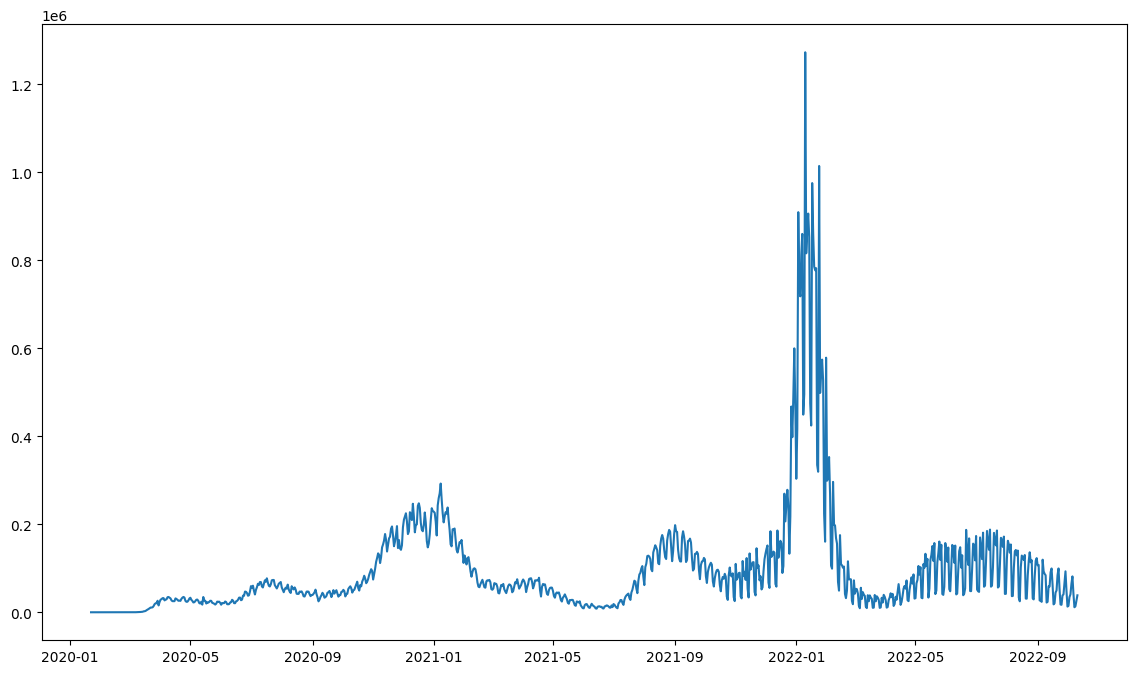

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df['new_case']);

In [ ]:
df = df.resample('W').mean()
df_cases_diff = df.copy()
df.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


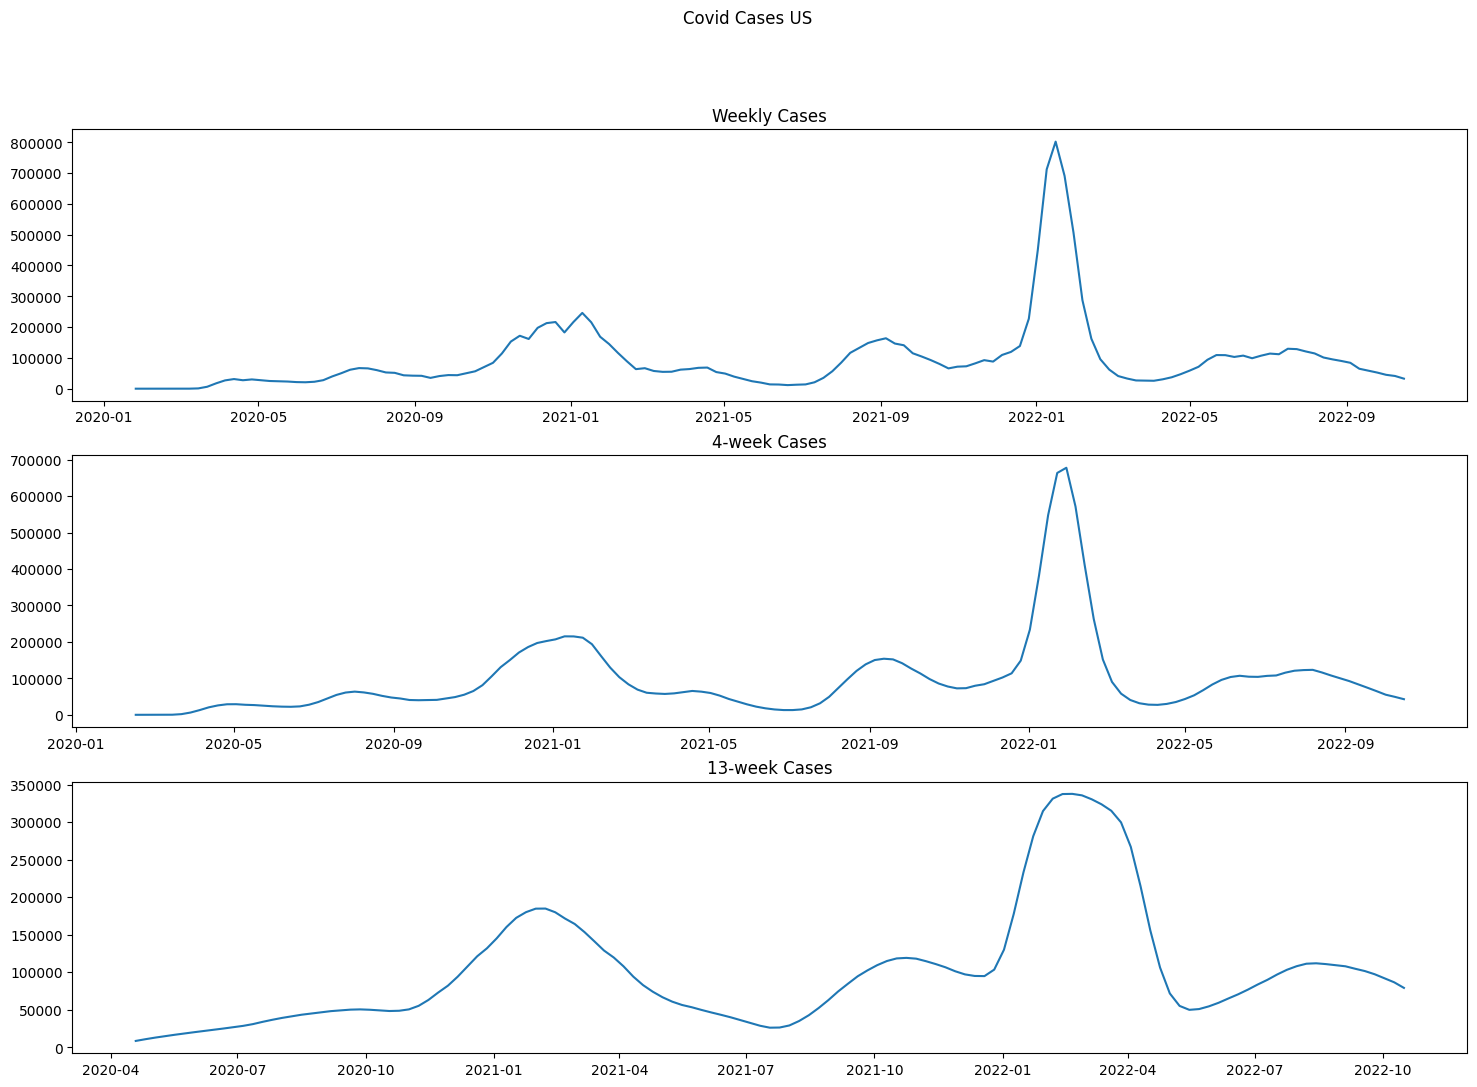

In [ ]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()

fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])


fig.suptitle('Covid Cases US')
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')



In [ ]:
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2020-04-19,27436.857143,27436.857143,25772.964286,8494.298901
2020-04-26,30087.571429,30087.571429,28939.857143,10808.604396
2020-05-03,27584.571429,27584.571429,29096.714286,12930.439560
2020-05-10,24957.142857,24957.142857,27516.535714,14850.142857
2020-05-17,24088.142857,24088.142857,26679.357143,16703.032967


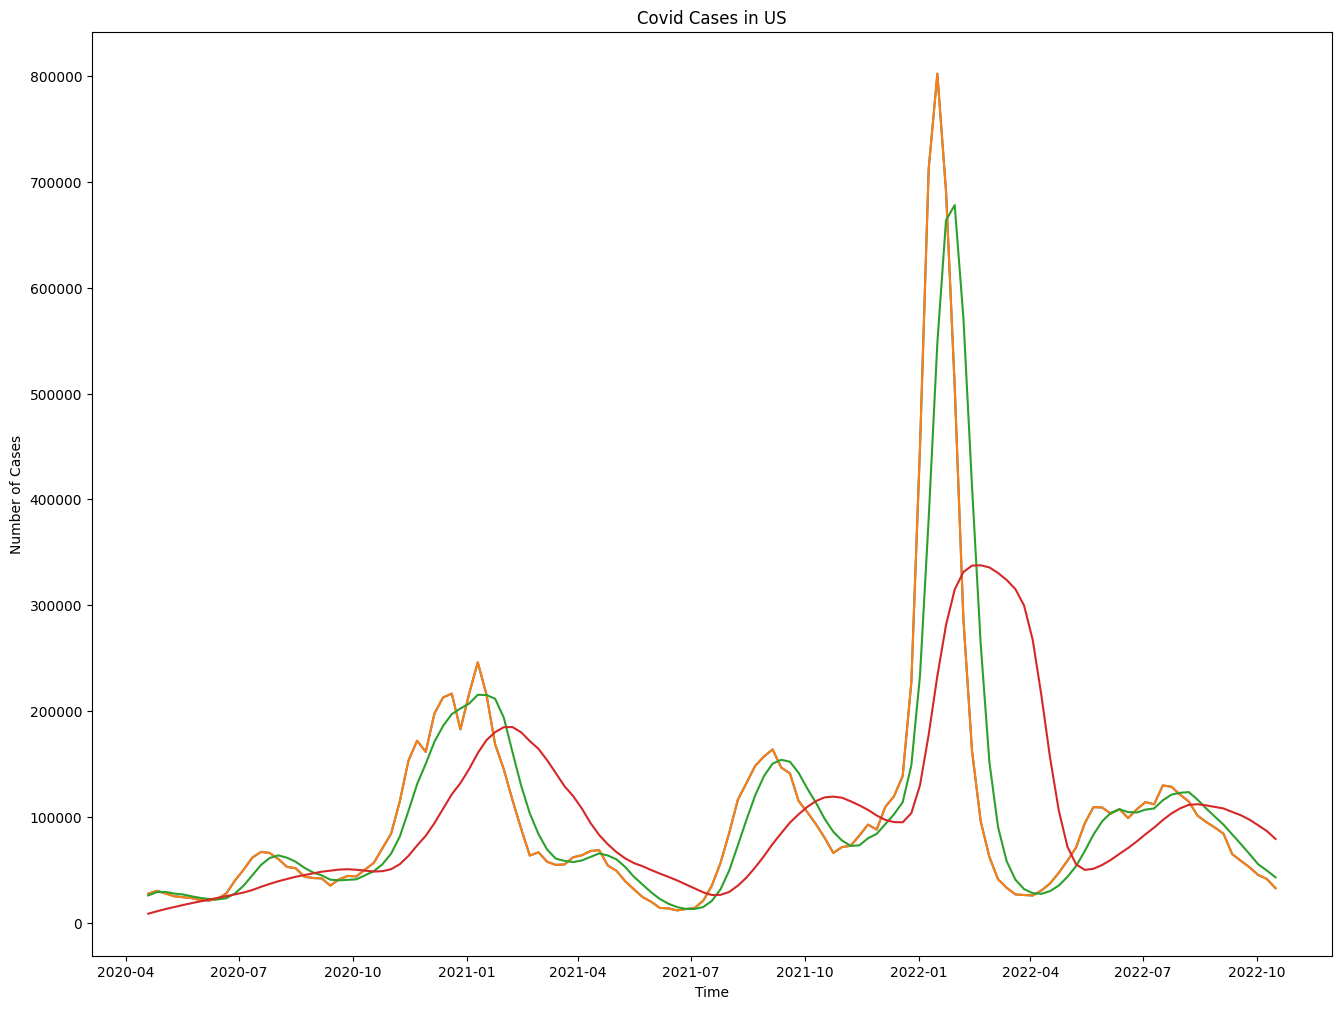

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(df)
plt.title('Covid Cases in US')
plt.xlabel('Time')
plt.ylabel('Number of Cases');

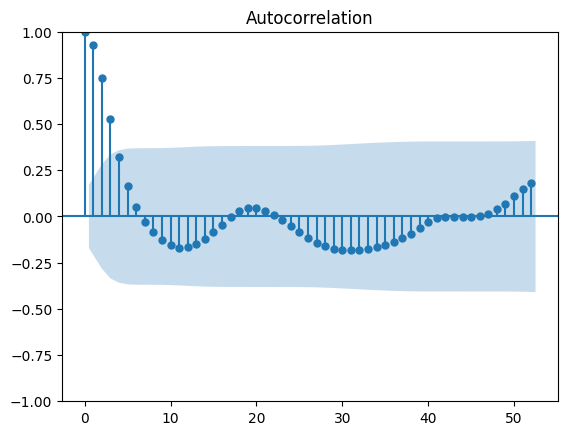

In [ ]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plot_acf(df['new_case'], lags = 52);

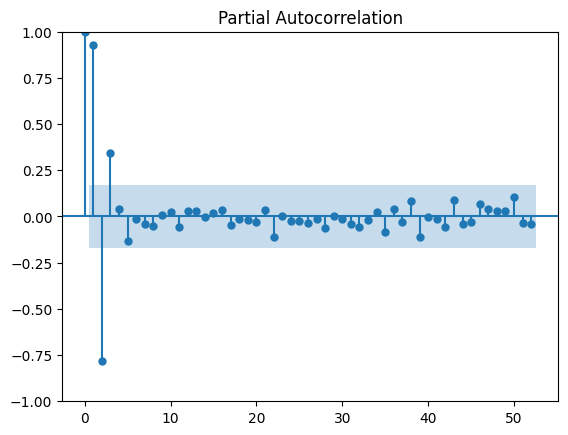

In [ ]:
plot_pacf(df['new_case'], lags = 52,method='ywm' );

### Evaluating Stationary
---

In [ ]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.264758
p-value           0.016529
dtype: float64

` Because our p (0.000014) is bigger than alpha (0.01) we can not  accept that our series "new_cases" is stationary.`

In [ ]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [ ]:
y_train.tail()

submission_date
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
2022-07-10    111881.000000
Freq: W-SUN, Name: new_case, dtype: float64

In [ ]:
y_test.head()

submission_date
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
2022-08-14    101213.571429
Freq: W-SUN, Name: new_case, dtype: float64

In [ ]:
# Instantiate best model.
#arima_5201 = ARIMA(endog = y_train, order = (52, 0, 1))
arima_5201 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_5201 = arima_5201.fit()

In [ ]:
# Generate predictions based on test set.
preds_5201 = model_5201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_5201 = model_5201.predict(start = y_train.index[0], end = y_train.index[-1])

In [ ]:
from sklearn import metrics
metrics.mean_squared_error(y_test, preds_5201)

1670137369.9166074

Text(0.5, 1.0, 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions')

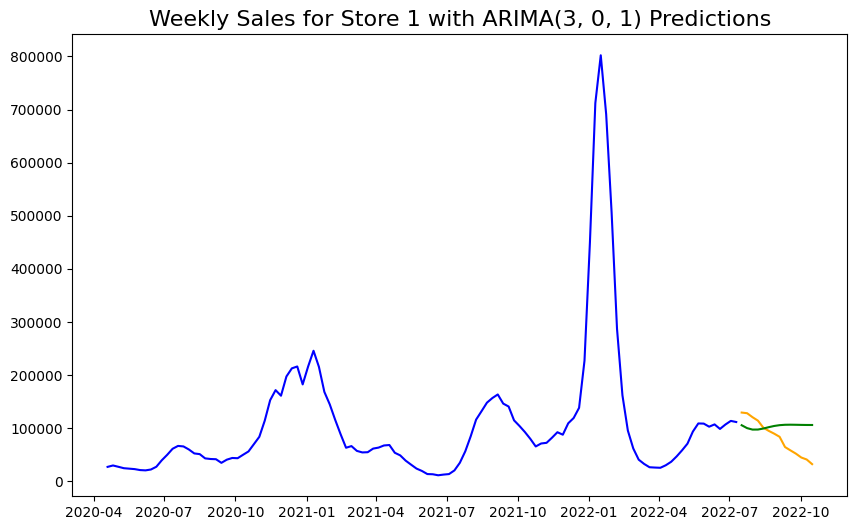

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_5201, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions', fontsize=16)

### SARIMA
----

In [ ]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1,1,1,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01876D+01    |proj g|=  1.53410D+00

At iterate    5    f=  9.61380D+00    |proj g|=  4.07626D-02

At iterate   10    f=  9.60119D+00    |proj g|=  5.82531D-03

At iterate   15    f=  9.59915D+00    |proj g|=  1.00265D-03

At iterate   20    f=  9.59915D+00    |proj g|=  1.96066D-04

At iterate   25    f=  9.59912D+00    |proj g|=  1.21236D-03

At iterate   30    f=  9.59910D+00    |proj g|=  3.40094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [ ]:
# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

In [ ]:
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

436286148.0807796

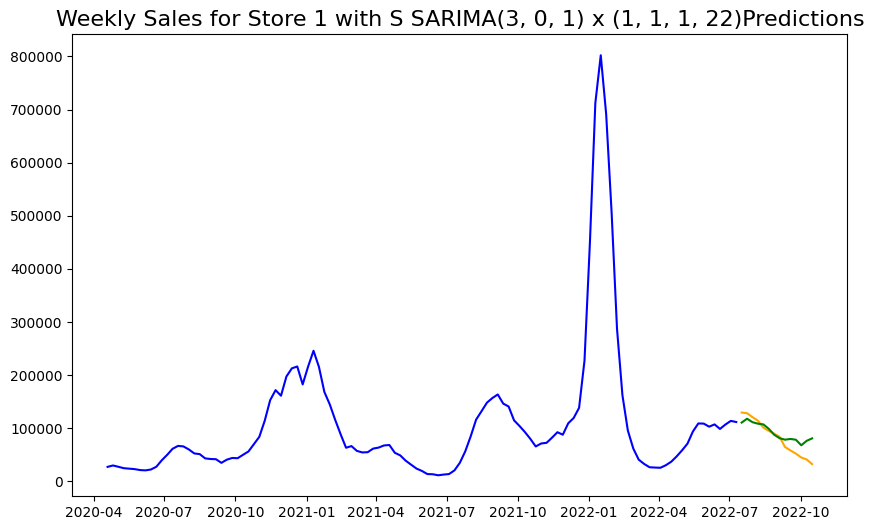

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'Weekly Sales for Store 1 with S SARIMA(3, 0, 1) x (1, 1, 1, 22)Predictions', fontsize=16)
plt.show();

In [ ]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [ ]:
df_cases_diff.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [ ]:
df_cases_diff['diff_1'] = df_cases_diff['new_case'].diff()
df_cases_diff['diff_2'] = df_cases_diff['new_case'].diff().diff()
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [ ]:
df_cases_diff.dropna(inplace=True)
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [ ]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df_cases_diff['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [ ]:
# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [ ]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [ ]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [ ]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
#CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
#Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,16).
#This model has an MSE of 990000000000000000.
#(1,0,0): 328044210.2485147
#(3,1,1):1835103241.9625137
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861503954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [ ]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.56195146

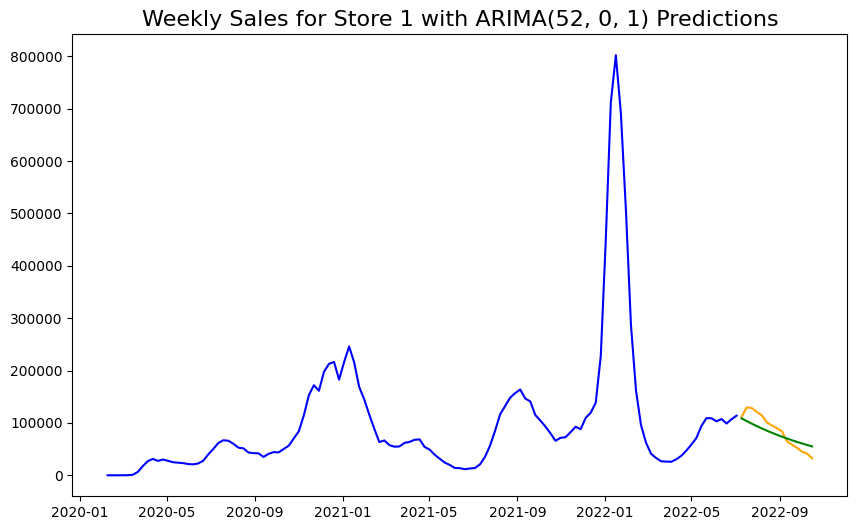

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.show();

In [ ]:
y_train.shape

(126,)

In [ ]:
y_test.shape

(15,)

In [ ]:

# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [ ]:
mse = 99 * (10 ** 16)
mse

990000000000000000

In [ ]:
metrics.mean_squared_error(y_test, preds_sarima)


328044210.56195146

In [ ]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_p = 0
final_d = 0
final_q = 0
final_P = 0
final_D = 0
final_Q = 0
for p in range(2):
    for q in range(2):
        for d in range(2):
            for P in range(3):
                for Q in range(3):
                    for D in range(3):
                        try:
                            sarima = SARIMAX(endog = y_train,
                                            order = (p, d, q),              # (p, d, q)
                                            seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                            
                            print(P, D, Q)
                            # Fit SARIMA model.
                            model = sarima.fit()
                            preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
                            print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')

                                            # Save for final report.
                            if mse > metrics.mean_squared_error(y_test, preds_sarima):
                                mse = metrics.mean_squared_error(y_test, preds_sarima)
                                
                                final_p = p
                                final_d = d
                                final_q = q
                                final_P = P
                                final_D = D
                                final_Q = Q

                            
                        except:
                            print("Exceprtion hahppened")
                            pass
print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
print(f'This model has an MSE of {mse}.')

0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34038D+01    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.776D-10   1.340D+01
  F =   13.403784634387565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,0,0,22) is: 8213489807.67483
0 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34402D+01    |proj g|=  4.06107D-02
The MSE for (0, 0, 0)x(0,0,1,22) is: 6255895107.926549
0 1 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   2.362D-06   1.344D+01
  F =   13.438659921937166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13065D+01    |proj g|=  1.66011D-01

At iterate    5    f=  1.12527D+01    |proj g|=  5.38236D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   5.382D-06   1.125D+01
  F =   11.252668436216467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,1,1,22) is: 1488023109.7789438
0 2 1


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28714D+00    |proj g|=  1.21567D-01

At iterate    5    f=  9.23219D+00    |proj g|=  9.82856D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   9.829D-07   9.232D+00
  F =   9.2321870018077554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,2,1,22) is: 7227596522.8898735
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


The MSE for (0, 0, 0)x(0,0,2,22) is: 3506836799.50045
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11954D+01    |proj g|=  3.75298D-01


 This problem is unconstrained.



At iterate    5    f=  1.10538D+01    |proj g|=  4.03802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   9.143D-06   1.105D+01
  F =   11.053732304786836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,1,2,22) is: 1111469286.4664068
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19696D+00    |proj g|=  3.00186D-01


 This problem is unconstrained.



At iterate    5    f=  8.98699D+00    |proj g|=  7.75488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   1.324D-06   8.987D+00
  F =   8.9869897730286983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,2,2,22) is: 4158051258.956403
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33373D+01    |proj g|=  6.59233D-02

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.


The MSE for (0, 0, 0)x(1,1,0,22) is: 1560516713.5881994
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25493D+00    |proj g|=  4.91407D-01


 This problem is unconstrained.



At iterate    5    f=  8.96969D+00    |proj g|=  7.35927D-03

At iterate   10    f=  8.96216D+00    |proj g|=  3.67469D-04

At iterate   15    f=  8.96115D+00    |proj g|=  1.84572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     18      1     0     0   5.569D-06   8.961D+00
  F =   8.9610620737010951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,2,0,22) is: 9933729694.237486
1 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33931D+01    |proj g|=  5.99029D-02

At iterate    5    f=  1.33884D+01    |proj g|=  2.93812D-02

At iterate   10    f=  1.33869D+01    |proj g|=  2.31548D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.315D-06   1.339D+01
  F =   13.386858442999046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,0,1,22) is: 3190425558.712294
1 1 1
RUNNING T

 This problem is unconstrained.



At iterate    5    f=  1.11201D+01    |proj g|=  1.10113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     16      1     0     0   1.988D-06   1.112D+01
  F =   11.120080481609435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,1,1,22) is: 1265342231.4392374
1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46869D+00    |proj g|=  8.26926D-01


 This problem is unconstrained.



At iterate    5    f=  8.80750D+00    |proj g|=  1.05910D-02

At iterate   10    f=  8.80297D+00    |proj g|=  9.70103D-04

At iterate   15    f=  8.80266D+00    |proj g|=  4.18153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     19      1     0     0   7.086D-06   8.803D+00
  F =   8.8026526685105306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,2,1,22) is: 4433476599.50073
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.



At iterate    5    f=  1.33309D+01    |proj g|=  8.94944D-02

At iterate   10    f=  1.33225D+01    |proj g|=  5.04046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   8.468D-06   1.332D+01
  F =   13.322482850600796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,0,2,22) is: 2184364369.3842745
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11954D+01    |proj g|=  3.75298D-01

At iterate    5    f=  1.10511D+01    |proj g|=  1.50885D-02

At iterate   10    f=  1.10504D+01    |proj g|=  2.16190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.470D-06   1.105D+01
  F =   11.050408163716078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,1,2,22) is: 1223660408.2641807
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.



At iterate    5    f=  8.96145D+00    |proj g|=  6.42331D-03

At iterate   10    f=  8.96050D+00    |proj g|=  2.06409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.406D-05   8.960D+00
  F =   8.9604847535664884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 0)x(1,2,2,22) is: 4410987251.330222
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35076D+01    |proj g|=  1.65634D-01

At itera

 This problem is unconstrained.


The MSE for (0, 0, 0)x(2,0,0,22) is: 2939055674.813101
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10448D+01    |proj g|=  5.37322D-02


 This problem is unconstrained.



At iterate    5    f=  1.10412D+01    |proj g|=  6.45072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.289D-06   1.104D+01
  F =   11.041233546914064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,1,0,22) is: 1227802513.3301198
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28595D+00    |proj g|=  5.51402D-01


 This problem is unconstrained.



At iterate    5    f=  8.85528D+00    |proj g|=  1.22451D-02

At iterate   10    f=  8.84600D+00    |proj g|=  6.39273D-03

At iterate   15    f=  8.84414D+00    |proj g|=  1.20000D-04

At iterate   20    f=  8.84382D+00    |proj g|=  1.61617D-04

At iterate   25    f=  8.84378D+00    |proj g|=  5.66303D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     33      1     0     0   3.897D-06   8.844D+00
  F =   8.8437674353227980     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,2,0,22) is: 17865493027.206776
2 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35305D+01    |proj g|=  1.80892D-01

At iterate    5    f=  1.33596D+01    |proj g|=  3.06032D-04

At iterate   10    f=  1.33595D+01    |proj g|=  8.58105D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   8.581D-06   1.336D+01
  F =   13.359545216999098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,0,1,22) is: 2981127987.661858
2 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12257D+01    |proj g|=  1.81743D-01

At iterate    5    f=  1.11167D+01    |proj g|=  8.98294D-04

At iterate   10    f=  1.11165D+01    |proj g|=  5.84293D-03

At iterate   15    f=  1.11156D+01    |proj g|=  2.62008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   1.456D-05   1.112D+01
  F =   11.115581152403889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60173D+01    |proj g|=  4.27165D+01

At iterate    5    f=  1.79661D+01    |proj g|=  1.01430D+00

At iterate   10    f=  1.69108D+01    |proj g|=  1.44575D-01

At iterate   15    f=  1.67841D+01    |proj g|=  5.12525D-02

At iterate   20    f=  1.67618D+01    |proj g|=  2.50784D-02

At iterate   25    f=  1.67585D+01    |proj g|=  9.89947D-03

At iterate   30    f=  1.66756D+01    |proj g|=  5.96976D-01

At iterate   35    f=  1.13026D+01    |proj g|=  2.07363D+00

At iterate   40    f=  8.86110D+00    |proj g|=  7.43532D-02

At iterate   45    f=  8.77290D+00    |proj g|=  7.19629D-03

At iterate   50    f=  8.77176D+00    |proj g|=  6.62723D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.33292D+01    |proj g|=  3.41248D-02

At iterate   10    f=  1.33244D+01    |proj g|=  1.52268D-03

At iterate   15    f=  1.33116D+01    |proj g|=  7.57318D-02

At iterate   20    f=  1.33059D+01    |proj g|=  7.29699D-03

At iterate   25    f=  1.33056D+01    |proj g|=  9.95563D-04

At iterate   30    f=  1.33055D+01    |proj g|=  9.30875D-03

At iterate   35    f=  1.33048D+01    |proj g|=  2.58191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     48      1     0     0   2.735D-05   1.330D+01
  F =   13.304761615125901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.10512D+01    |proj g|=  1.25989D-02

At iterate   10    f=  1.10504D+01    |proj g|=  1.14971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   6.406D-05   1.105D+01
  F =   11.050372080154668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 0)x(2,1,2,22) is: 1222511634.20952
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19696D+00    |proj g|=  3.00186D-01


 This problem is unconstrained.



At iterate    5    f=  8.96076D+00    |proj g|=  9.64632D-03

At iterate   10    f=  8.95663D+00    |proj g|=  5.11928D-03

At iterate   15    f=  8.95392D+00    |proj g|=  9.75338D-03

At iterate   20    f=  8.95335D+00    |proj g|=  9.58363D-04

At iterate   25    f=  8.95319D+00    |proj g|=  4.70058D-04

At iterate   30    f=  8.95317D+00    |proj g|=  3.02001D-04

At iterate   35    f=  8.95317D+00    |proj g|=  1.68036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     43      1     0     0   9.422D-06   8.953D+00
  F =   8.9531642534234077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21756D+01    |proj g|=  2.89822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   8.189D-06   1.217D+01
  F =   12.174701509673202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,0,1,22) is: 1033154209.9540958
0 1 1


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03311D+01    |proj g|=  3.25699D-02

At iterate    5    f=  1.03245D+01    |proj g|=  5.63140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   5.631D-06   1.032D+01
  F =   10.324529179429769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,1,1,22) is: 33081260409.89515
0 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51834D+00    |proj g|=  7.10066D-02

At iterate    5    f=  8.48533D+00    |proj g|=  2.66543D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   2.665D-06   8.485D+00
  F =   8.4853267384682898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,2,1,22) is: 322519439683.8225
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

 This problem is unconstrained.


The MSE for (0, 1, 0)x(0,0,2,22) is: 1092765609.7396307
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02298D+01    |proj g|=  3.08908D-01


 This problem is unconstrained.



At iterate    5    f=  1.00981D+01    |proj g|=  4.27203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.073D-06   1.010D+01
  F =   10.098023879276800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,1,2,22) is: 7011791250.97115
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36888D+00    |proj g|=  2.31479D-01


 This problem is unconstrained.



At iterate    5    f=  8.19002D+00    |proj g|=  3.22438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   3.526D-06   8.190D+00
  F =   8.1899927267460484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,2,2,22) is: 118092780052.42436
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20826D+01    |proj g|=  1.15847D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


The MSE for (0, 1, 0)x(1,1,0,22) is: 7559845605.063689
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41121D+00    |proj g|=  3.59572D-01


 This problem is unconstrained.



At iterate    5    f=  8.17936D+00    |proj g|=  6.45778D-03

At iterate   10    f=  8.17180D+00    |proj g|=  3.21059D-04

At iterate   15    f=  8.17080D+00    |proj g|=  1.60757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     17      1     0     0   8.814D-06   8.171D+00
  F =   8.1707442873951237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,2,0,22) is: 191701594989.09406
1 0 1


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21742D+01    |proj g|=  2.65185D-02

At iterate    5    f=  1.21735D+01    |proj g|=  5.18362D-03

At iterate   10    f=  1.21734D+01    |proj g|=  1.04093D-05
The MSE for (0, 1, 0)x(1,0,1,22) is: 1032873410.567627
1 1 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     24      1     0     0   1.041D-05   1.217D+01
  F =   12.173350256735890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02146D+01    |proj g|=  3.27305D-02

At iterate    5    f=  1.02125D+01    |proj g|=  1.40292D-02

At iterate   10    f=  1.02118D+01    |proj g|=  2.62598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   5.768D-06   1.021D+01
  F =   10.211835396469304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,1,1,22) is: 6731390603.446147
1 2 1
RUNNING T

 This problem is unconstrained.



At iterate    5    f=  8.05397D+00    |proj g|=  8.71588D-03

At iterate   10    f=  8.04942D+00    |proj g|=  1.09462D-03

At iterate   15    f=  8.04884D+00    |proj g|=  8.63395D-05

At iterate   20    f=  8.04874D+00    |proj g|=  1.16541D-05

At iterate   25    f=  8.04872D+00    |proj g|=  1.00320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   5.778D-06   8.049D+00
  F =   8.0487139576446953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,2,1,22) is: 26446308192.11187
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  1.20726D+01    |proj g|=  6.34452D-03

At iterate   10    f=  1.20711D+01    |proj g|=  3.12910D-03

At iterate   15    f=  1.20710D+01    |proj g|=  2.39728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   5.218D-06   1.207D+01
  F =   12.071027953686931     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,0,2,22) is: 1122934547.9862564
1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02298D+01    |proj g|=  3.08908D-01

At iterate    5    f=  1.00943D+01    |proj g|=  4.52853D-03

At iterate   10    f=  1.00928D+01    |proj g|=  9.18224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   8.106D-06   1.009D+01
  F =   10.092791779809039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,1,2,22) is: 3735599292.808519
1 2 2
RUNNING T

 This problem is unconstrained.



At iterate    5    f=  8.16660D+00    |proj g|=  6.56034D-03

At iterate   10    f=  8.16468D+00    |proj g|=  2.75867D-03

At iterate   15    f=  8.16442D+00    |proj g|=  3.14501D-04

At iterate   20    f=  8.16436D+00    |proj g|=  1.32676D-04

At iterate   25    f=  8.16435D+00    |proj g|=  2.16750D-04

At iterate   30    f=  8.16434D+00    |proj g|=  5.75691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     54      1     0     0   5.755D-04   8.164D+00
  F =   8.1643447952063486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The MSE for (0, 1, 0)x(1,2,2,22) is: 51208468621.92225
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21636D+01    |proj g|=  1.54512D-01

At iterate    5    f=  1.21066D+01    |proj g|=  2.48269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   5.707D-06   1.211D+01
  F =   12.106601912620807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


The MSE for (0, 1, 0)x(2,0,0,22) is: 1077846551.0967965
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01219D+01    |proj g|=  5.37309D-02


 This problem is unconstrained.



At iterate    5    f=  1.01137D+01    |proj g|=  1.29824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   4.578D-06   1.011D+01
  F =   10.113688236835378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,1,0,22) is: 7069494879.185353
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38479D+00    |proj g|=  3.02374D-01


 This problem is unconstrained.



At iterate    5    f=  8.11712D+00    |proj g|=  5.38347D-03

At iterate   10    f=  8.11557D+00    |proj g|=  1.72431D-03

At iterate   15    f=  8.11416D+00    |proj g|=  1.56478D-04

At iterate   20    f=  8.11401D+00    |proj g|=  6.30612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   7.964D-06   8.114D+00
  F =   8.1139826286371495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,2,0,22) is: 91853501112.14322
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.



At iterate    5    f=  1.21684D+01    |proj g|=  2.00550D-03

At iterate   10    f=  1.21682D+01    |proj g|=  3.94836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   7.548D-06   1.217D+01
  F =   12.168183655780007     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,0,1,22) is: 1140509299.4296172
2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02130D+01    |proj g|=  1.70261D-02


 This problem is unconstrained.



At iterate    5    f=  1.02097D+01    |proj g|=  8.62362D-04

At iterate   10    f=  1.02091D+01    |proj g|=  3.41304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   5.784D-06   1.021D+01
  F =   10.209023144235445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,1,1,22) is: 5635929422.028054
2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67548D+01    |proj g|=  6.83028D+00


 This problem is unconstrained.



At iterate    5    f=  9.80510D+00    |proj g|=  1.63099D-01

At iterate   10    f=  9.62993D+00    |proj g|=  4.00209D-02

At iterate   15    f=  9.60060D+00    |proj g|=  4.27743D-03

At iterate   20    f=  9.59561D+00    |proj g|=  8.76814D-04

At iterate   25    f=  9.59418D+00    |proj g|=  5.19887D-03

At iterate   30    f=  8.38199D+00    |proj g|=  2.57622D-02

At iterate   35    f=  8.04035D+00    |proj g|=  5.79706D-03

At iterate   40    f=  8.04020D+00    |proj g|=  2.23605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     56      1     0     0   1.911D-05   8.040D+00
  F =   8.04016042301

 This problem is unconstrained.



At iterate   10    f=  1.20702D+01    |proj g|=  1.19767D-03

At iterate   15    f=  1.20701D+01    |proj g|=  1.22945D-02

At iterate   20    f=  1.20697D+01    |proj g|=  3.91854D-03

At iterate   25    f=  1.20696D+01    |proj g|=  3.24882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   2.161D-05   1.207D+01
  F =   12.069638607490690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(2,0,2,22) is: 1400481894.8319046
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.00928D+01    |proj g|=  2.30650D-03

At iterate   10    f=  1.00927D+01    |proj g|=  5.87793D-04

At iterate   15    f=  1.00927D+01    |proj g|=  2.37948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   2.401D-05   1.009D+01
  F =   10.092684174452968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(2,1,2,22) is: 3758666465.8648214
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.16677D+00    |proj g|=  6.16224D-03

At iterate   10    f=  8.16144D+00    |proj g|=  3.99749D-03

At iterate   15    f=  8.16054D+00    |proj g|=  3.26247D-03

At iterate   20    f=  8.16016D+00    |proj g|=  7.58519D-04

At iterate   25    f=  8.16002D+00    |proj g|=  1.10744D-03

At iterate   30    f=  8.15999D+00    |proj g|=  1.18275D-04

At iterate   35    f=  8.15999D+00    |proj g|=  1.03036D-04

At iterate   40    f=  8.15999D+00    |proj g|=  4.14301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     47      1     0     0   4.143D-05   8.160D+00
  F =   8.15998656137

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.92564D+00    |proj g|=  5.62607D-03

At iterate   10    f=  8.92164D+00    |proj g|=  1.42056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     13      1     0     0   7.372D-06   8.922D+00
  F =   8.9216115158537672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,0,22) is: 7287850801.464283
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33415D+01    |proj g|=  9.29840D-01

At itera

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12152D+01    |proj g|=  9.50869D-01

At iterate    5    f=  1.08093D+01    |proj g|=  6.99099D-03

At iterate   10    f=  1.08066D+01    |proj g|=  8.83206D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     13      1     0     0   3.904D-06   1.081D+01
  F =   10.806578148747594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,1,1,22) is: 1111365786.3844836
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20314D+00    |proj g|=  7.25199D-01


 This problem is unconstrained.



At iterate    5    f=  8.88267D+00    |proj g|=  6.81729D-03

At iterate   10    f=  8.87951D+00    |proj g|=  6.67630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     13      1     0     0   2.023D-06   8.880D+00
  F =   8.8795050163121374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,1,22) is: 3540610422.362431
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34079D+01    |proj g|=  1.08400D+00

At itera

 This problem is unconstrained.



At iterate   10    f=  1.29925D+01    |proj g|=  1.30272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.905D-04   1.299D+01
  F =   12.992435121699925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 1)x(0,0,2,22) is: 4993748505.187479
0 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12047D+01    |proj g|=  9.31851D-01

At iterate    5    f=  1.08036D+01    |proj g|=  1.29214D-02

At iterate   10    f=  1.08006D+01    |proj g|=  1.53948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   4.415D-06   1.080D+01
  F =   10.800572792448166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,1,2,22) is: 974083122.9738615
0 2 2
RUNNING T

 This problem is unconstrained.



At iterate    5    f=  8.86567D+00    |proj g|=  9.67853D-03

At iterate   10    f=  8.86165D+00    |proj g|=  2.03081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.855D-06   8.862D+00
  F =   8.8616517367831946     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,2,22) is: 3174890033.3303504
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33298D+01    |proj g|=  8.89192D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08003D+01    |proj g|=  3.79943D-03

At iterate   10    f=  1.07993D+01    |proj g|=  7.91935D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   7.919D-06   1.080D+01
  F =   10.799328767896407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,1,0,22) is: 1186769147.4069905
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20314D+00    |proj g|=  7.25199D-01


 This problem is unconstrained.



At iterate    5    f=  8.87064D+00    |proj g|=  6.06141D-03

At iterate   10    f=  8.86486D+00    |proj g|=  3.13640D-04

At iterate   15    f=  8.86437D+00    |proj g|=  7.65265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   6.160D-06   8.864D+00
  F =   8.8643108974891618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,0,22) is: 5714007023.020072
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   10    f=  1.29907D+01    |proj g|=  2.41767D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   2.595D-05   1.299D+01
  F =   12.990672219713552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 1)x(1,0,1,22) is: 4274052513.5769925
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11396D+01    |proj g|=  8.06011D-01

At iterate    5    f=  1.08029D+01    |proj g|=  1.37559D-02


 This problem is unconstrained.



At iterate   10    f=  1.07982D+01    |proj g|=  4.46035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   8.818D-06   1.080D+01
  F =   10.798179769532346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,1,1,22) is: 1015881170.4317223
1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20314D+00    |proj g|=  7.25199D-01


 This problem is unconstrained.



At iterate    5    f=  8.85562D+00    |proj g|=  6.40386D-03

At iterate   10    f=  8.85197D+00    |proj g|=  5.57844D-04

At iterate   15    f=  8.85158D+00    |proj g|=  1.07558D-03

At iterate   20    f=  8.85150D+00    |proj g|=  1.06660D-04

At iterate   25    f=  8.85148D+00    |proj g|=  1.61547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     29      1     0     0   7.343D-06   8.851D+00
  F =   8.8514817662337197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,1,22) is: 3676433707.6816773
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.30014D+01    |proj g|=  2.07243D-02

At iterate   10    f=  1.29911D+01    |proj g|=  4.23092D-03

At iterate   15    f=  1.29907D+01    |proj g|=  1.11744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   7.968D-06   1.299D+01
  F =   12.990671701970081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,0,2,22) is: 4272863847.8870454
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.08017D+01    |proj g|=  2.32973D-02

At iterate   10    f=  1.07982D+01    |proj g|=  6.60843D-04

At iterate   15    f=  1.07982D+01    |proj g|=  1.57520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   3.728D-06   1.080D+01
  F =   10.798174293498757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,1,2,22) is: 1020381940.8152021
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.85509D+00    |proj g|=  9.73371D-03

At iterate   10    f=  8.84932D+00    |proj g|=  1.40390D-03

At iterate   15    f=  8.84914D+00    |proj g|=  8.22443D-04

At iterate   20    f=  8.84913D+00    |proj g|=  1.83848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   5.063D-06   8.849D+00
  F =   8.8491275655134842     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,2,22) is: 3793611526.908423
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.



At iterate    5    f=  1.30006D+01    |proj g|=  3.29945D-02

At iterate   10    f=  1.29916D+01    |proj g|=  2.33579D-03

At iterate   15    f=  1.29910D+01    |proj g|=  2.76557D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   9.313D-06   1.299D+01
  F =   12.991009288783742     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,0,0,22) is: 4472368767.03678
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.



At iterate    5    f=  1.07994D+01    |proj g|=  1.59019D-02

At iterate   10    f=  1.07982D+01    |proj g|=  2.41269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   3.727D-06   1.080D+01
  F =   10.798201682742659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,0,22) is: 1038125571.8165869
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20314D+00    |proj g|=  7.25199D-01

At iterate    5    f=  8.84833D+00    |proj g|=  2.45659D-03

At iterate   10    f=  8.84778D+00    |proj g|=  1.15461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   8.875D-06   8.848D+00
  F =   8.8477764230296128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,2,0,22) is: 10578906182.703287
2 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34686D+01    |proj g|=  7.60892D-01

At iterate    5    f=  1.30022D+01    |proj g|=  2.45266D-02

At iterate   10    f=  1.29911D+01    |proj g|=  1.83725D-03

At iterate   15    f=  1.29907D+01    |proj g|=  4.85923D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   4.859D-06   1.299D+01
  F =   12.990671756535962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

 This problem is unconstrained.



At iterate    5    f=  1.08021D+01    |proj g|=  1.18867D-02

At iterate   10    f=  1.07987D+01    |proj g|=  6.23984D-04

At iterate   15    f=  1.07983D+01    |proj g|=  1.74871D-03

At iterate   20    f=  1.07982D+01    |proj g|=  5.81958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.728D-06   1.080D+01
  F =   10.798175972108387     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,1,22) is: 1018951132.6236292
2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.84910D+00    |proj g|=  7.35307D-03

At iterate   10    f=  8.84691D+00    |proj g|=  2.70164D-04

At iterate   15    f=  8.84689D+00    |proj g|=  5.81117D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   5.811D-06   8.847D+00
  F =   8.8468937876746008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,2,1,22) is: 8475549895.940622
2 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.30065D+01    |proj g|=  3.26855D-02

At iterate   10    f=  1.29911D+01    |proj g|=  3.86955D-03

At iterate   15    f=  1.29907D+01    |proj g|=  6.25365D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   3.520D-05   1.299D+01
  F =   12.990662812391282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 1)x(2,0,2,22) is: 4310616731.98513
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.



At iterate    5    f=  1.08011D+01    |proj g|=  8.19500D-03

At iterate   10    f=  1.07982D+01    |proj g|=  1.47991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   9.604D-06   1.080D+01
  F =   10.798168612987272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,2,22) is: 1020126267.5942273
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20314D+00    |proj g|=  7.25199D-01


 This problem is unconstrained.



At iterate    5    f=  8.85579D+00    |proj g|=  1.16842D-02

At iterate   10    f=  8.84817D+00    |proj g|=  2.95084D-03

At iterate   15    f=  8.84691D+00    |proj g|=  1.43147D-03

At iterate   20    f=  8.84688D+00    |proj g|=  2.87927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.927D-06   8.847D+00
  F =   8.8468811918824368     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,2,2,22) is: 8313150705.875251
0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


The MSE for (0, 1, 1)x(0,2,0,22) is: 411902841201.52057
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21486D+01    |proj g|=  1.22369D+00

At iterate    5    f=  1.17024D+01    |proj g|=  9.93605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   7.045D-06   1.170D+01
  F =   11.702400645246430     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,0,1,22) is: 1618388805.8629913
0 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00774D+01    |proj g|=  6.57936D-01

At iterate    5    f=  9.83872D+00    |proj g|=  3.51344D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   7.858D-06   9.839D+00
  F =   9.8387189782964573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


The MSE for (0, 1, 1)x(0,1,1,22) is: 10793772925.615396
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42215D+00    |proj g|=  6.57475D-01


 This problem is unconstrained.



At iterate    5    f=  8.04574D+00    |proj g|=  2.51167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   4.115D-06   8.046D+00
  F =   8.0456824115160472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,2,1,22) is: 179931289518.83218
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21480D+01    |proj g|=  1.22236D+00


 This problem is unconstrained.



At iterate    5    f=  1.17015D+01    |proj g|=  1.64727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      7      1     0     0   7.140D-06   1.170D+01
  F =   11.701468746851198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,0,2,22) is: 1858019320.0031617
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02943D+01    |proj g|=  9.17263D-01


 This problem is unconstrained.



At iterate    5    f=  9.82841D+00    |proj g|=  4.64188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   7.978D-06   9.828D+00
  F =   9.8283368817704293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,1,2,22) is: 4425591614.531354
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42215D+00    |proj g|=  6.57475D-01


 This problem is unconstrained.



At iterate    5    f=  8.00392D+00    |proj g|=  1.84842D-02

At iterate   10    f=  8.00262D+00    |proj g|=  7.63047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   6.772D-06   8.003D+00
  F =   8.0026172426691460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,2,2,22) is: 91724161533.88672
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21454D+01    |proj g|=  1.21339D+00

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.83595D+00    |proj g|=  7.33703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.238D-06   9.836D+00
  F =   9.8359435561882300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,1,0,22) is: 8089958384.215959
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42215D+00    |proj g|=  6.57475D-01


 This problem is unconstrained.



At iterate    5    f=  8.03966D+00    |proj g|=  9.09035D-03

At iterate   10    f=  8.03294D+00    |proj g|=  5.61962D-04

At iterate   15    f=  8.03207D+00    |proj g|=  5.59658D-04

At iterate   20    f=  8.03195D+00    |proj g|=  9.35136D-05

At iterate   25    f=  8.03193D+00    |proj g|=  7.33452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     35      1     0     0   7.898D-05   8.032D+00
  F =   8.0319273943409470     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(1,2,0,22) is: 128534020371.87852
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.17020D+01    |proj g|=  4.10453D-04

At iterate   25    f=  1.17020D+01    |proj g|=  7.08375D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     27      1     0     0   7.084D-06   1.170D+01
  F =   11.702032839026291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,0,1,22) is: 2121435842.3978622
1 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00831D+01    |proj g|=  7.05010D-01

At iterate    5    f=  9.83464D+00    |proj g|=  1.20572D-02

At iterate   10    f=  9.82651D+00    |proj g|=  9.63105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     17      1     0     0   9.132D-05   9.827D+00
  F =   9.8265082811885840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(1,1,1,22) is: 3409164576.262681
1 2 1
RUNNING T

 This problem is unconstrained.



At iterate    5    f=  7.99363D+00    |proj g|=  7.04045D-03

At iterate   10    f=  7.99018D+00    |proj g|=  1.18574D-03

At iterate   15    f=  7.98986D+00    |proj g|=  1.74063D-04

At iterate   20    f=  7.98982D+00    |proj g|=  6.64382D-05

At iterate   25    f=  7.98981D+00    |proj g|=  2.12120D-05

At iterate   30    f=  7.98970D+00    |proj g|=  5.56668D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     65      2     0     0   1.853D-05   7.990D+00
  F =   7.9896984546307177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(1,2,1,22) is: 44925071534.51309
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21480D+01    |proj g|=  1.22236D+00

At iterate    5    f=  1.17015D+01    |proj g|=  5.72589D-04


 This problem is unconstrained.



At iterate   10    f=  1.17013D+01    |proj g|=  4.40583D-03

At iterate   15    f=  1.17013D+01    |proj g|=  7.16014D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   7.160D-06   1.170D+01
  F =   11.701276878281078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,0,2,22) is: 1880505033.5307546
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02943D+01    |proj g|=  9.17263D-01


 This problem is unconstrained.



At iterate    5    f=  9.82653D+00    |proj g|=  1.60309D-03

At iterate   10    f=  9.82639D+00    |proj g|=  1.00131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   7.876D-06   9.826D+00
  F =   9.8263867686399760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,1,2,22) is: 3097839174.5399837
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42215D+00    |proj g|=  6.57475D-01


 This problem is unconstrained.



At iterate    5    f=  7.98518D+00    |proj g|=  5.17943D-03

At iterate   10    f=  7.98400D+00    |proj g|=  5.93355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   5.342D-06   7.984D+00
  F =   7.9839872846812536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,2,2,22) is: 47327118527.36475
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21886D+01    |proj g|=  1.15223D+00

At itera

 This problem is unconstrained.



At iterate   10    f=  1.17015D+01    |proj g|=  7.14006D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   7.140D-06   1.170D+01
  F =   11.701466038685767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,0,0,22) is: 1822629082.6466157
2 1 0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00804D+01    |proj g|=  6.91837D-01

At iterate    5    f=  9.82911D+00    |proj g|=  1.29206D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   7.678D-06   9.829D+00
  F =   9.8290982488656429     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,1,0,22) is: 6334671830.301586
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

 This problem is unconstrained.



At iterate    5    f=  7.98095D+00    |proj g|=  4.62351D-03

At iterate   10    f=  7.97810D+00    |proj g|=  2.84353D-03

At iterate   15    f=  7.97728D+00    |proj g|=  1.35528D-04

At iterate   20    f=  7.97716D+00    |proj g|=  4.94597D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   5.339D-06   7.977D+00
  F =   7.9771325011891001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,2,0,22) is: 99439071242.70036
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.



At iterate   10    f=  1.17013D+01    |proj g|=  1.38389D-03

At iterate   15    f=  1.17013D+01    |proj g|=  4.82259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   4.348D-05   1.170D+01
  F =   11.701249578636759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(2,0,1,22) is: 1910923696.930046
2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00784D+01    |proj g|=  6.95387D-01


 This problem is unconstrained.



At iterate    5    f=  9.82888D+00    |proj g|=  5.22007D-03

At iterate   10    f=  9.82644D+00    |proj g|=  1.30237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   7.877D-06   9.826D+00
  F =   9.8264290176895024     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,1,1,22) is: 3234984759.540336
2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42215D+00    |proj g|=  6.57475D-01


 This problem is unconstrained.



At iterate    5    f=  7.98119D+00    |proj g|=  9.65462D-03

At iterate   10    f=  7.97629D+00    |proj g|=  2.30809D-03

At iterate   15    f=  7.97564D+00    |proj g|=  6.08143D-04

At iterate   20    f=  7.97551D+00    |proj g|=  2.76583D-04

At iterate   25    f=  7.97548D+00    |proj g|=  7.94681D-04

At iterate   30    f=  7.97548D+00    |proj g|=  1.82356D-04

At iterate   35    f=  7.97548D+00    |proj g|=  3.68878D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     43      1     0     0   3.689D-05   7.975D+00
  F =   7.9754774651294280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.17015D+01    |proj g|=  1.01844D-03

At iterate   10    f=  1.17013D+01    |proj g|=  3.28886D-03

At iterate   15    f=  1.17013D+01    |proj g|=  3.73414D-04

At iterate   20    f=  1.17012D+01    |proj g|=  7.73903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   3.877D-05   1.170D+01
  F =   11.701225364415176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(2,0,2,22) is: 1979022417.9894106
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  9.82646D+00    |proj g|=  1.30311D-03

At iterate   10    f=  9.82642D+00    |proj g|=  2.21121D-04

At iterate   15    f=  9.82639D+00    |proj g|=  1.20678D-03

At iterate   20    f=  9.82632D+00    |proj g|=  1.13238D-03

At iterate   25    f=  9.82630D+00    |proj g|=  5.01961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   7.884D-06   9.826D+00
  F =   9.8262998276244673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,1,2,22) is: 2971648890.296681
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  7.98405D+00    |proj g|=  8.46080D-03

At iterate   10    f=  7.97874D+00    |proj g|=  4.03948D-03

At iterate   15    f=  7.97611D+00    |proj g|=  2.61862D-03

At iterate   20    f=  7.97549D+00    |proj g|=  5.42638D-04

At iterate   25    f=  7.97534D+00    |proj g|=  8.45859D-04

At iterate   30    f=  7.97532D+00    |proj g|=  7.87255D-05

At iterate   35    f=  7.97531D+00    |proj g|=  1.95802D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     52      1     0     0   2.394D-04   7.975D+00
  F =   7.9753132913273772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(2,2,2,22) is: 80574467227.15071
0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21981D+01    |proj g|=  2.00617D-01

At iterate    5    f=  1.21657D+01    |proj g|=  1.18503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.524D-06   1.217D+01
  F =   12.165566085891001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,0,1,22) is: 1260766350.2323813
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


The MSE for (1, 0, 0)x(0,1,1,22) is: 7710592131.028634
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46631D+00    |proj g|=  2.24360D-01


 This problem is unconstrained.



At iterate    5    f=  8.34001D+00    |proj g|=  2.03489D-04

At iterate   10    f=  8.33996D+00    |proj g|=  1.16083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   2.801D-06   8.340D+00
  F =   8.3399389506424306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,2,1,22) is: 160497838747.128
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  6.33286D-02

At iterat

 This problem is unconstrained.



At iterate   10    f=  1.21651D+01    |proj g|=  7.12575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.065D-05   1.217D+01
  F =   12.165055635956014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(0,0,2,22) is: 1154059007.9340537
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03194D+01    |proj g|=  3.08683D-01


 This problem is unconstrained.



At iterate    5    f=  1.01891D+01    |proj g|=  3.90473D-03

At iterate   10    f=  1.01886D+01    |proj g|=  8.54431D-03

At iterate   15    f=  1.01885D+01    |proj g|=  4.48565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   4.486D-06   1.019D+01
  F =   10.188454668479904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,1,2,22) is: 3996954828.7886815
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.29427D+00    |proj g|=  3.13120D-03

At iterate   10    f=  8.29412D+00    |proj g|=  4.94309D-03

At iterate   15    f=  8.29349D+00    |proj g|=  2.48287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   3.650D-06   8.293D+00
  F =   8.2934859771528959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,2,2,22) is: 57077004882.21205
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.01897D+01    |proj g|=  3.49754D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   4.193D-06   1.019D+01
  F =   10.189683532959785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,1,0,22) is: 4652452940.267872
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46631D+00    |proj g|=  2.24359D-01


 This problem is unconstrained.



At iterate    5    f=  8.32126D+00    |proj g|=  4.03970D-03

At iterate   10    f=  8.31635D+00    |proj g|=  1.95812D-04

At iterate   15    f=  8.31573D+00    |proj g|=  1.26793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   2.845D-06   8.316D+00
  F =   8.3156350502811023     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,2,0,22) is: 105332489377.83862
1 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21829D+01    |proj g|=  1.56996D-01

At iterate    5    f=  1.21665D+01    |proj g|=  2.14798D-02

At iterate   10    f=  1.21654D+01    |proj g|=  1.30355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   6.828D-06   1.217D+01
  F =   12.165435501855548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,0,1,22) is: 1263007416.5083966
1 1 1
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  1.01851D+01    |proj g|=  2.89931D-04

At iterate   15    f=  1.01851D+01    |proj g|=  5.46176D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   5.462D-06   1.019D+01
  F =   10.185143629009316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,1,1,22) is: 3237679888.4703293
1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46631D+00    |proj g|=  2.24360D-01


 This problem is unconstrained.



At iterate    5    f=  8.27597D+00    |proj g|=  3.59320D-03

At iterate   10    f=  8.27206D+00    |proj g|=  1.47959D-03

At iterate   15    f=  8.27178D+00    |proj g|=  1.08822D-03

At iterate   20    f=  8.27166D+00    |proj g|=  3.04167D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     26      1     0     0   8.069D-06   8.272D+00
  F =   8.2716307873862451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,2,1,22) is: 24676715818.504074
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.21648D+01    |proj g|=  1.27552D-02

At iterate   10    f=  1.21644D+01    |proj g|=  6.39351D-03

At iterate   15    f=  1.21639D+01    |proj g|=  2.56297D-03

At iterate   20    f=  1.21639D+01    |proj g|=  4.37618D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   4.376D-05   1.216D+01
  F =   12.163891901819783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(1,0,2,22) is: 1276278839.2970417
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.01857D+01    |proj g|=  5.16049D-03

At iterate   10    f=  1.01841D+01    |proj g|=  5.73470D-03

At iterate   15    f=  1.01839D+01    |proj g|=  8.14106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   4.513D-06   1.018D+01
  F =   10.183922428815404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,1,2,22) is: 2587220005.036476
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  8.27045D+00    |proj g|=  8.66240D-03

At iterate   10    f=  8.26752D+00    |proj g|=  9.18888D-03

At iterate   15    f=  8.26721D+00    |proj g|=  1.01740D-03

At iterate   20    f=  8.26707D+00    |proj g|=  2.28960D-04

At iterate   25    f=  8.26704D+00    |proj g|=  2.42747D-04

At iterate   30    f=  8.26704D+00    |proj g|=  6.02792D-05

At iterate   35    f=  8.26704D+00    |proj g|=  1.67971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     44      1     0     0   1.306D-04   8.267D+00
  F =   8.2670366952786409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.21647D+01    |proj g|=  3.89339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   3.106D-06   1.216D+01
  F =   12.164640918988814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,0,0,22) is: 1214431328.0043395
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01899D+01    |proj g|=  3.21884D-02


 This problem is unconstrained.



At iterate    5    f=  1.01875D+01    |proj g|=  2.06192D-03

At iterate   10    f=  1.01868D+01    |proj g|=  1.91467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   4.559D-05   1.019D+01
  F =   10.186807321849221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,1,0,22) is: 4148697398.3209105
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46631D+00    |proj g|=  2.24359D-01


 This problem is unconstrained.



At iterate    5    f=  8.27045D+00    |proj g|=  2.28912D-03

At iterate   10    f=  8.26902D+00    |proj g|=  1.44130D-03

At iterate   15    f=  8.26868D+00    |proj g|=  9.07097D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   9.071D-06   8.269D+00
  F =   8.2686787087574558     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,2,0,22) is: 43402678249.91015
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   10    f=  1.21636D+01    |proj g|=  2.77699D-04

At iterate   15    f=  1.21636D+01    |proj g|=  3.36965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.898D-05   1.216D+01
  F =   12.163613344477117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,0,1,22) is: 1270322887.333747
2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03191D+01    |proj g|=  1.85873D-01


 This problem is unconstrained.



At iterate    5    f=  1.01898D+01    |proj g|=  2.47302D-03

At iterate   10    f=  1.01888D+01    |proj g|=  1.03058D-03

At iterate   15    f=  1.01844D+01    |proj g|=  3.77260D-03

At iterate   20    f=  1.01840D+01    |proj g|=  9.23050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     0     0   6.913D-06   1.018D+01
  F =   10.184049261604603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,1,1,22) is: 2950997455.2778697
2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.26825D+00    |proj g|=  2.24622D-02

At iterate   10    f=  8.26638D+00    |proj g|=  1.95652D-03

At iterate   15    f=  8.26539D+00    |proj g|=  8.17586D-04

At iterate   20    f=  8.26530D+00    |proj g|=  7.32486D-04

At iterate   25    f=  8.26526D+00    |proj g|=  1.50999D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   3.874D-06   8.265D+00
  F =   8.2652598635757517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,2,1,22) is: 28418399882.506485
2 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.21631D+01    |proj g|=  4.26115D-03

At iterate   15    f=  1.21629D+01    |proj g|=  1.24081D-03

At iterate   20    f=  1.21627D+01    |proj g|=  7.34541D-03

At iterate   25    f=  1.21627D+01    |proj g|=  2.24115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     42      1     0     0   2.352D-05   1.216D+01
  F =   12.162713529942785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,0,2,22) is: 958666061.2540257
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate    5    f=  1.01847D+01    |proj g|=  2.18601D-03

At iterate   10    f=  1.01842D+01    |proj g|=  9.07022D-03

At iterate   15    f=  1.01839D+01    |proj g|=  4.40813D-04

At iterate   20    f=  1.01839D+01    |proj g|=  1.22046D-03

At iterate   25    f=  1.01839D+01    |proj g|=  8.21938D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     26      1     0     0   8.219D-06   1.018D+01
  F =   10.183871242456274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,1,2,22) is: 2648914448.943392
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  8.27140D+00    |proj g|=  6.37696D-03

At iterate   10    f=  8.26628D+00    |proj g|=  2.55706D-03

At iterate   15    f=  8.26578D+00    |proj g|=  2.60140D-03

At iterate   20    f=  8.26531D+00    |proj g|=  2.35241D-04

At iterate   25    f=  8.26519D+00    |proj g|=  2.28748D-03

At iterate   30    f=  8.26511D+00    |proj g|=  1.32887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   1.230D-05   8.265D+00
  F =   8.2651086077775311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,2,2,22) is: 27690109167.07

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16648D+01    |proj g|=  1.05923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   4.473D-05   1.166D+01
  F =   11.664781842819776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(0,0,1,22) is: 3395606306.0882063
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


The MSE for (1, 1, 0)x(0,1,1,22) is: 3990456644.7807617
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63341D-01


 This problem is unconstrained.



At iterate    5    f=  8.04850D+00    |proj g|=  1.65910D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   8.099D-06   8.048D+00
  F =   8.0484974069486093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,2,1,22) is: 12340350243.832163
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16648D+01    |proj g|=  2.89894D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


The MSE for (1, 1, 0)x(0,0,2,22) is: 3404578222.6458483
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95444D+00    |proj g|=  3.72974D-01


 This problem is unconstrained.



At iterate    5    f=  9.78567D+00    |proj g|=  3.46333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.876D-06   9.786D+00
  F =   9.7856431355701545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,1,2,22) is: 1403100804.4392238
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63341D-01


 This problem is unconstrained.



At iterate    5    f=  7.99624D+00    |proj g|=  7.62487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   5.215D-06   7.996D+00
  F =   7.9962304358977576     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,2,2,22) is: 5636819965.127609
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16672D+01    |proj g|=  7.16668D-02

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.317D-06   9.786D+00
  F =   9.7855387060282180     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,1,0,22) is: 1677161275.0283039
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63338D-01


 This problem is unconstrained.



At iterate    5    f=  8.02561D+00    |proj g|=  4.30677D-03

At iterate   10    f=  8.02085D+00    |proj g|=  6.07039D-04

At iterate   15    f=  8.02003D+00    |proj g|=  6.81268D-05

At iterate   20    f=  8.01993D+00    |proj g|=  4.14175D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   4.142D-06   8.020D+00
  F =   8.0199309602618349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,2,0,22) is: 10127389658.041626
1 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16648D+01    |proj g|=  8.93119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   2.409D-05   1.166D+01
  F =   11.664782153698821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(1,0,1,22) is: 3392527290.0787034
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  9.77982D+00    |proj g|=  2.66339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   7.760D-06   9.780D+00
  F =   9.7797617566855077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,1,1,22) is: 949152555.337647
1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63341D-01


 This problem is unconstrained.



At iterate    5    f=  7.97722D+00    |proj g|=  3.83981D-03

At iterate   10    f=  7.97448D+00    |proj g|=  1.44754D-03

At iterate   15    f=  7.97384D+00    |proj g|=  7.24341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   6.100D-06   7.974D+00
  F =   7.9737791596639829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,2,1,22) is: 5827891252.861681
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.16648D+01    |proj g|=  1.95381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   1.954D-05   1.166D+01
  F =   11.664781549621337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(1,0,2,22) is: 3404955401.9261527
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95444D+00    |proj g|=  3.72974D-01


 This problem is unconstrained.



At iterate    5    f=  9.78033D+00    |proj g|=  4.10516D-03

At iterate   10    f=  9.77924D+00    |proj g|=  2.51237D-03

At iterate   15    f=  9.77919D+00    |proj g|=  9.47509D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   9.475D-06   9.779D+00
  F =   9.7791861364062616     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,1,2,22) is: 930304027.8096678
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63341D-01

At iterate    5    f=  7.96852D+00    |proj g|=  3.84727D-03

At iterate   10    f=  7.96711D+00    |proj g|=  6.14947D-04

At iterate   15    f=  7.96699D+00    |proj g|=  1.07271D-04

At iterate   20    f=  7.96698D+00    |proj g|=  1.44137D-04

At iterate   25    f=  7.96697D+00    |proj g|=  1.66567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     40      1     0     0   3.117D-04   7.967D+00
  F =   7.9669684271940424     

CONVERGENCE: REL_RED

 This problem is unconstrained.



At iterate    5    f=  1.16648D+01    |proj g|=  1.68893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.129D-06   1.166D+01
  F =   11.664781512665860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,0,0,22) is: 3405212795.297792
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78879D+00    |proj g|=  3.15963D-02


 This problem is unconstrained.



At iterate    5    f=  9.78135D+00    |proj g|=  5.71429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.609D-06   9.781D+00
  F =   9.7813517111914070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,1,0,22) is: 1285125330.5307014
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18735D+00    |proj g|=  2.63338D-01


 This problem is unconstrained.



At iterate    5    f=  7.96630D+00    |proj g|=  5.74181D-03

At iterate   10    f=  7.96495D+00    |proj g|=  1.67414D-03

At iterate   15    f=  7.96270D+00    |proj g|=  2.84926D-04

At iterate   20    f=  7.96227D+00    |proj g|=  5.19277D-05

At iterate   25    f=  7.96221D+00    |proj g|=  1.69341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   6.274D-06   7.962D+00
  F =   7.9621919586215215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,2,0,22) is: 25263902487.44977
2 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17285D+01    |proj g|=  1.77490D-01

At iterate    5    f=  1.16648D+01    |proj g|=  2.78887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     10      1     0     0   1.937D-05   1.166D+01
  F =   11.664780664895849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(2,0,1,22) is: 3415019317.899104
2 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78785D+00    |proj g|=  5.99030D-02

At iterate    5    f=  9.78054D+00    |proj g|=  5.32202D-03

At iterate   10    f=  9.77948D+00    |proj g|=  3.95919D-03

At iterate   15    f=  9.77932D+00    |proj g|=  5.90953D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   8.988D-06   9.779D+00
  F =   9.7793185858087242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

 This problem is unconstrained.



At iterate    5    f=  7.96407D+00    |proj g|=  9.00864D-03

At iterate   10    f=  7.96182D+00    |proj g|=  1.60005D-03

At iterate   15    f=  7.96063D+00    |proj g|=  5.50420D-04

At iterate   20    f=  7.96038D+00    |proj g|=  7.55354D-04

At iterate   25    f=  7.96030D+00    |proj g|=  5.78913D-04

At iterate   30    f=  7.96028D+00    |proj g|=  3.18869D-04
  ys=-6.001E-03  -gs= 6.754E-05 BFGS update SKIPPED

At iterate   35    f=  7.96023D+00    |proj g|=  4.79206D-03
  ys=-4.849E-03  -gs= 4.007E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     66      1     2     0   2

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4      6      1     0     0   3.599D-05   1.166D+01
  F =   11.664781540118566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(2,0,2,22) is: 3405317385.5431275
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95444D+00    |proj g|=  3.72974D-01


 This problem is unconstrained.



At iterate    5    f=  9.77936D+00    |proj g|=  2.33860D-03

At iterate   10    f=  9.77932D+00    |proj g|=  5.08164D-04

At iterate   15    f=  9.77924D+00    |proj g|=  2.67961D-03

At iterate   20    f=  9.77917D+00    |proj g|=  3.28957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   7.782D-06   9.779D+00
  F =   9.7791672701677061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,1,2,22) is: 921009901.239737
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10



 This problem is unconstrained.



At iterate    5    f=  7.96849D+00    |proj g|=  8.30847D-03

At iterate   10    f=  7.96275D+00    |proj g|=  2.55649D-03

At iterate   15    f=  7.96086D+00    |proj g|=  7.29327D-03

At iterate   20    f=  7.96034D+00    |proj g|=  1.10174D-03

At iterate   25    f=  7.96006D+00    |proj g|=  5.60087D-04

At iterate   30    f=  7.96001D+00    |proj g|=  1.91504D-04

At iterate   35    f=  7.96000D+00    |proj g|=  2.17991D-04
  ys=-5.501E-05  -gs= 9.336E-06 BFGS update SKIPPED

At iterate   40    f=  7.95995D+00    |proj g|=  1.72271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     70      1     1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.25892D+00    |proj g|=  8.45917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   7.323D-06   8.259D+00
  F =   8.2586490458495252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,2,0,22) is: 191304323401.75174
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24470D+01    |proj g|=  1.73869D+00


 This problem is unconstrained.



At iterate    5    f=  1.17731D+01    |proj g|=  5.62603D-03

At iterate   10    f=  1.17725D+01    |proj g|=  1.26921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   2.150D-06   1.177D+01
  F =   11.772533664176402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,0,1,22) is: 663516015.152288
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05149D+01    |proj g|=  1.31677D+00


 This problem is unconstrained.



At iterate    5    f=  9.87666D+00    |proj g|=  3.56104D-03

At iterate   10    f=  9.87636D+00    |proj g|=  3.33705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   7.078D-06   9.876D+00
  F =   9.8763637913642590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,1,1,22) is: 4528976954.178439
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66499D+00    |proj g|=  1.07781D+00


 This problem is unconstrained.



At iterate    5    f=  8.08316D+00    |proj g|=  7.38101D-03

At iterate   10    f=  8.08241D+00    |proj g|=  3.78922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   8.472D-06   8.082D+00
  F =   8.0824057307230248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,2,1,22) is: 69025997432.79417
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24072D+01    |proj g|=  1.75173D+00

At itera

 This problem is unconstrained.



At iterate   10    f=  1.17717D+01    |proj g|=  4.59103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     13      1     0     0   9.523D-06   1.177D+01
  F =   11.771704701667545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,0,2,22) is: 624996337.7075979
0 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04985D+01    |proj g|=  1.29582D+00

At iterate    5    f=  9.86661D+00    |proj g|=  5.35426D-03

At iterate   10    f=  9.86623D+00    |proj g|=  1.58390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     13      1     0     0   1.004D-05   9.866D+00
  F =   9.8662254565080563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(0,1,2,22) is: 1975991562.8539262
0 2 2
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  8.02176D+00    |proj g|=  5.51960D-03

At iterate   10    f=  8.02158D+00    |proj g|=  6.26205D-05

At iterate   15    f=  8.02158D+00    |proj g|=  6.13376D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   6.134D-06   8.022D+00
  F =   8.0215797950804504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,2,2,22) is: 25732501872.636913
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   8.083D-06   9.880D+00
  F =   9.8798901526515017     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,1,0,22) is: 4107323120.6806607
1 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66499D+00    |proj g|=  1.07781D+00


 This problem is unconstrained.



At iterate    5    f=  8.08322D+00    |proj g|=  1.39617D-02

At iterate   10    f=  8.07311D+00    |proj g|=  9.05830D-04

At iterate   15    f=  8.07168D+00    |proj g|=  1.07961D-03

At iterate   20    f=  8.07150D+00    |proj g|=  6.94337D-04

At iterate   25    f=  8.07147D+00    |proj g|=  3.41357D-05

At iterate   30    f=  8.07147D+00    |proj g|=  9.62626D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     34      1     0     0   9.626D-06   8.071D+00
  F =   8.0714662901349783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,2,0,22) is: 45630327391.98

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   6.793D-06   1.177D+01
  F =   11.772343674189459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,0,1,22) is: 744530518.6950643
1 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03953D+01    |proj g|=  1.16318D+00

At iterate    5    f=  9.87377D+00    |proj g|=  2.66020D-02

At iterate   10    f=  9.86507D+00    |proj g|=  4.31707D-04

At iterate   15    f=  9.86507D+00    |proj g|=  6.98696D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     24      1     0     0   6.978D-06   9.865D+00
  F =   9.8650660557566638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

 This problem is unconstrained.



At iterate    5    f=  8.01139D+00    |proj g|=  1.03740D-02

At iterate   10    f=  8.00673D+00    |proj g|=  5.03223D-04

At iterate   15    f=  8.00633D+00    |proj g|=  7.84664D-04

At iterate   20    f=  8.00625D+00    |proj g|=  1.89009D-04

At iterate   25    f=  8.00624D+00    |proj g|=  2.85873D-05

At iterate   30    f=  8.00623D+00    |proj g|=  3.11129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     53      1     0     0   7.981D-04   8.006D+00
  F =   8.0062038225696917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(1,2,1,22) is: 11235293795.66

 This problem is unconstrained.



At iterate   10    f=  1.17717D+01    |proj g|=  5.42521D-04

At iterate   15    f=  1.17716D+01    |proj g|=  2.67014D-03

At iterate   20    f=  1.17716D+01    |proj g|=  6.04388D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   6.044D-06   1.177D+01
  F =   11.771566468763400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,0,2,22) is: 635442928.2698667
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  9.86530D+00    |proj g|=  2.99223D-03

At iterate   10    f=  9.86503D+00    |proj g|=  1.53249D-04

At iterate   15    f=  9.86503D+00    |proj g|=  6.97451D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     16      1     0     0   6.975D-06   9.865D+00
  F =   9.8650258076726942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,1,2,22) is: 1824529299.3577795
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.99985D+00    |proj g|=  4.37849D-03

At iterate   10    f=  7.99894D+00    |proj g|=  4.65850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     13      1     0     0   7.554D-06   7.999D+00
  F =   7.9989381865511122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,2,2,22) is: 12735325108.964983
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27332D+01    |proj g|=  1.88422D+00


 This problem is unconstrained.



At iterate    5    f=  1.17815D+01    |proj g|=  6.97592D-02

At iterate   10    f=  1.17717D+01    |proj g|=  4.22843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   4.446D-06   1.177D+01
  F =   11.771654849460427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,0,0,22) is: 623385896.6000024
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01915D+01    |proj g|=  9.06242D-01


 This problem is unconstrained.



At iterate    5    f=  9.86916D+00    |proj g|=  2.65162D-03

At iterate   10    f=  9.86898D+00    |proj g|=  8.63807D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     11      1     0     0   8.638D-06   9.869D+00
  F =   9.8689813468180443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,1,0,22) is: 3349016162.107004
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66499D+00    |proj g|=  1.07781D+00


 This problem is unconstrained.



At iterate    5    f=  8.00093D+00    |proj g|=  6.48915D-03

At iterate   10    f=  7.99917D+00    |proj g|=  8.92562D-04

At iterate   15    f=  7.99915D+00    |proj g|=  8.72236D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   8.722D-06   7.999D+00
  F =   7.9991468383628836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,2,0,22) is: 44888970200.131256
2 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27013D+01    |proj g|=  1.87095D+00

At iterate    5    f=  1.17776D+01    |proj g|=  4.73154D-02

At iterate   10    f=  1.17721D+01    |proj g|=  7.21795D-03

At iterate   15    f=  1.17717D+01    |proj g|=  4.05832D-04

At iterate   20    f=  1.17715D+01    |proj g|=  3.16434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   2.687D-05   1.177D+01
  F =   11.771531097568268     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04662D+01    |proj g|=  1.20711D+00

At iterate    5    f=  9.87739D+00    |proj g|=  1.74511D-02

At iterate   10    f=  9.87196D+00    |proj g|=  4.59886D-02

At iterate   15    f=  9.86707D+00    |proj g|=  3.32050D-03

At iterate   20    f=  9.86557D+00    |proj g|=  1.05672D-02

At iterate   25    f=  9.86504D+00    |proj g|=  6.16730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.99737D+00    |proj g|=  1.56502D-02

At iterate   10    f=  7.99336D+00    |proj g|=  2.29734D-03

At iterate   15    f=  7.99334D+00    |proj g|=  1.58474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     17      1     0     0   3.352D-05   7.993D+00
  F =   7.9933424715057271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(2,2,1,22) is: 27785558021.56712
2 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.17724D+01    |proj g|=  6.18041D-03

At iterate   10    f=  1.17717D+01    |proj g|=  5.16684D-04

At iterate   15    f=  1.17716D+01    |proj g|=  5.73989D-03

At iterate   20    f=  1.17715D+01    |proj g|=  1.38202D-04

At iterate   25    f=  1.17715D+01    |proj g|=  8.28167D-04

At iterate   30    f=  1.17715D+01    |proj g|=  8.66716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   8.667D-05   1.177D+01
  F =   11.771468651743954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(2,0,2,22) is: 536849504.1972

 This problem is unconstrained.



At iterate    5    f=  9.86534D+00    |proj g|=  3.28117D-03

At iterate   10    f=  9.86503D+00    |proj g|=  1.48927D-03

At iterate   15    f=  9.86503D+00    |proj g|=  3.14276D-04

At iterate   20    f=  9.86499D+00    |proj g|=  1.41243D-03

At iterate   25    f=  9.86493D+00    |proj g|=  6.88992D-04

At iterate   30    f=  9.86489D+00    |proj g|=  1.92089D-04

At iterate   35    f=  9.86489D+00    |proj g|=  1.02397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     42      1     0     0   1.373D-05   9.865D+00
  F =   9.8648911824953611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66499D+00    |proj g|=  1.07781D+00

At iterate    5    f=  7.99874D+00    |proj g|=  9.75829D-03

At iterate   10    f=  7.99434D+00    |proj g|=  3.65336D-03

At iterate   15    f=  7.99319D+00    |proj g|=  2.17701D-04

At iterate   20    f=  7.99319D+00    |proj g|=  2.30948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     22      1     0     0   2.309D-05   7.993D+00
  F =   7.9931900620208154     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.09309D+00    |proj g|=  1.78165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   3.676D-06   8.093D+00
  F =   8.0930862309008482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,0,22) is: 56255147334.52457
0 0 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15395D+01    |proj g|=  2.05796D-01

At iterate    5    f=  1.15063D+01    |proj g|=  2.92284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   5.939D-06   1.151D+01
  F =   11.506257888504344     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,0,1,22) is: 1876602202.929127
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

 This problem is unconstrained.



At iterate    5    f=  9.70287D+00    |proj g|=  8.18650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   9.594D-06   9.703D+00
  F =   9.7028714094973925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,1,1,22) is: 1374135254.443581
0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85934D-01


 This problem is unconstrained.



At iterate    5    f=  7.97188D+00    |proj g|=  5.74078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   7.828D-06   7.972D+00
  F =   7.9718772789595764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,1,22) is: 19466851184.329224
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15400D+01    |proj g|=  2.07170D-01


 This problem is unconstrained.



At iterate    5    f=  1.15060D+01    |proj g|=  5.80293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.599D-05   1.151D+01
  F =   11.506009391176903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(0,0,2,22) is: 2021000838.2782042
0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86957D+00    |proj g|=  3.50541D-01


 This problem is unconstrained.



At iterate    5    f=  9.68867D+00    |proj g|=  1.38602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8      9      1     0     0   9.885D-06   9.689D+00
  F =   9.6886587096650807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,1,2,22) is: 863722979.6421522
0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85934D-01


 This problem is unconstrained.



At iterate    5    f=  7.92793D+00    |proj g|=  3.37256D-03

At iterate   10    f=  7.92781D+00    |proj g|=  5.97282D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     11      1     0     0   5.973D-06   7.928D+00
  F =   7.9278135351568331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,2,22) is: 11839986691.911848
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15479D+01    |proj g|=  2.21296D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.69974D+00    |proj g|=  8.74251D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   8.743D-06   9.700D+00
  F =   9.6997399256844794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,1,0,22) is: 2430127226.021334
1 2 0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85931D-01

At iterate    5    f=  7.96457D+00    |proj g|=  2.35457D-02

At iterate   10    f=  7.95971D+00    |proj g|=  2.94359D-03

At iterate   15    f=  7.95897D+00    |proj g|=  3.63362D-04

At iterate   20    f=  7.95885D+00    |proj g|=  2.28192D-04

At iterate   25    f=  7.95883D+00    |proj g|=  2.12411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The MSE for (1, 1, 1)x(1,2,0,22) is: 17257541492.343216
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15396D+01    |proj g|=  2.06035D-01

At iterate    5    f=  1.15062D+01    |proj g|=  1.22082D-03


 This problem is unconstrained.



At iterate   10    f=  1.15062D+01    |proj g|=  1.78782D-03

At iterate   15    f=  1.15061D+01    |proj g|=  1.17649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   4.541D-06   1.151D+01
  F =   11.506117084053828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,0,1,22) is: 1971703004.153127
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74348D+00    |proj g|=  1.66877D-01


 This problem is unconstrained.



At iterate    5    f=  9.69675D+00    |proj g|=  6.20467D-03

At iterate   10    f=  9.68915D+00    |proj g|=  1.73233D-02

At iterate   15    f=  9.68649D+00    |proj g|=  4.00656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   9.755D-06   9.686D+00
  F =   9.6864848035197060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,1,1,22) is: 940965661.9180954
1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  7.91840D+00    |proj g|=  7.37183D-03

At iterate   10    f=  7.91645D+00    |proj g|=  1.32941D-03

At iterate   15    f=  7.91624D+00    |proj g|=  4.60049D-04

At iterate   20    f=  7.91622D+00    |proj g|=  4.61998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   3.627D-05   7.916D+00
  F =   7.9162216596820913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,2,1,22) is: 10824491017.572437
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.15060D+01    |proj g|=  1.29811D-03

At iterate   10    f=  1.15060D+01    |proj g|=  4.36235D-04

At iterate   15    f=  1.15060D+01    |proj g|=  1.22561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   1.455D-05   1.151D+01
  F =   11.505983731062706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,0,2,22) is: 1971838804.1716185
1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.68649D+00    |proj g|=  1.73513D-03

At iterate   10    f=  9.68647D+00    |proj g|=  4.58088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   1.106D-05   9.686D+00
  F =   9.6864700982606102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,1,2,22) is: 933135351.6640091
1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85934D-01


 This problem is unconstrained.



At iterate    5    f=  7.90981D+00    |proj g|=  3.23806D-03

At iterate   10    f=  7.90921D+00    |proj g|=  1.33456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     15      1     0     0   6.241D-06   7.909D+00
  F =   7.9091927519719674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,2,2,22) is: 14224289566.307806
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16215D+01    |proj g|=  2.69963D-01


 This problem is unconstrained.



At iterate    5    f=  1.15060D+01    |proj g|=  3.20632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   3.012D-05   1.151D+01
  F =   11.505999077439254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,0,0,22) is: 2018665357.4502828
2 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71125D+00    |proj g|=  9.50222D-02


 This problem is unconstrained.



At iterate    5    f=  9.68963D+00    |proj g|=  8.19826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   9.480D-06   9.690D+00
  F =   9.6896272543296291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,1,0,22) is: 1826287024.0945392
2 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85931D-01


 This problem is unconstrained.



At iterate    5    f=  7.90825D+00    |proj g|=  7.56393D-03

At iterate   10    f=  7.90466D+00    |proj g|=  1.17257D-02

At iterate   15    f=  7.90240D+00    |proj g|=  1.21659D-03

At iterate   20    f=  7.90209D+00    |proj g|=  5.22203D-04

At iterate   25    f=  7.90205D+00    |proj g|=  1.20156D-04

At iterate   30    f=  7.90204D+00    |proj g|=  3.95343D-04

At iterate   35    f=  7.90204D+00    |proj g|=  6.06732D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     40      1     0     0   6.067D-06   7.902D+00
  F =   7.9020360626983557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.15061D+01    |proj g|=  6.06950D-03

At iterate   10    f=  1.15060D+01    |proj g|=  4.60933D-04

At iterate   15    f=  1.15060D+01    |proj g|=  2.36945D-03

At iterate   20    f=  1.15060D+01    |proj g|=  1.37046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     34      1     0     0   1.370D-05   1.151D+01
  F =   11.505982425144655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The MSE for (1, 1, 1)x(2,0,1,22) is: 1973204475.0397909
2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71706D+00    |proj g|=  1.16607D-01


 This problem is unconstrained.



At iterate    5    f=  9.68874D+00    |proj g|=  4.79452D-03

At iterate   10    f=  9.68648D+00    |proj g|=  3.56740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   4.870D-05   9.686D+00
  F =   9.6864750378497995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,1,1,22) is: 936291310.6738168
2 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85934D-01

At iterate    5    f=  7.90483D+00    |proj g|=  9.84221D-03

At iterate   10    f=  7.90123D+00    |proj g|=  6.53744D-03

At iterate   15    f=  7.90069D+00    |proj g|=  2.26615D-03

At iterate   20    f=  7.90045D+00    |proj g|=  6.53423D-04

At iterate   25    f=  7.90041D+00    |proj g|=  1.77148D-04

At iterate   30    f=  7.90040D+00    |proj g|=  9.51476D-05

At iterate   35    f=  7.90040D+00    |proj g|=  1.64301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  1.15060D+01    |proj g|=  3.11077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      8     10      1     0     0   7.666D-05   1.151D+01
  F =   11.506004676704965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,0,2,22) is: 2020398180.592861
2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86957D+00    |proj g|=  3.50541D-01


 This problem is unconstrained.



At iterate    5    f=  9.68654D+00    |proj g|=  3.14670D-03

At iterate   10    f=  9.68647D+00    |proj g|=  7.74575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     13      1     0     0   5.031D-05   9.686D+00
  F =   9.6864747676512852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,1,2,22) is: 935351564.6210153
2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13290D+00    |proj g|=  2.85934D-01


 This problem is unconstrained.



At iterate    5    f=  7.90852D+00    |proj g|=  6.25959D-03

At iterate   10    f=  7.90362D+00    |proj g|=  1.20702D-02

At iterate   15    f=  7.90119D+00    |proj g|=  6.41154D-03

At iterate   20    f=  7.90037D+00    |proj g|=  1.58030D-03

At iterate   25    f=  7.90022D+00    |proj g|=  3.37170D-04

At iterate   30    f=  7.90019D+00    |proj g|=  4.08725D-04

At iterate   35    f=  7.90018D+00    |proj g|=  1.91222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     50      1     0     0   3.670D-04   7.900D+00
  F =   7.9001801306625259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [ ]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147
# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467
# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### Cases by State
____

In [ ]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [ ]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [ ]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [ ]:
df_cases.head(60).sort_values(by='state')

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AK,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,AR,0,0,0,0
2020-01-22,AS,0,0,0,0
2020-01-22,AZ,0,0,0,0
2020-01-22,CA,0,0,0,0
2020-01-22,CO,0,0,0,0
2020-01-22,CT,0,0,0,0
2020-01-22,DC,0,0,0,0


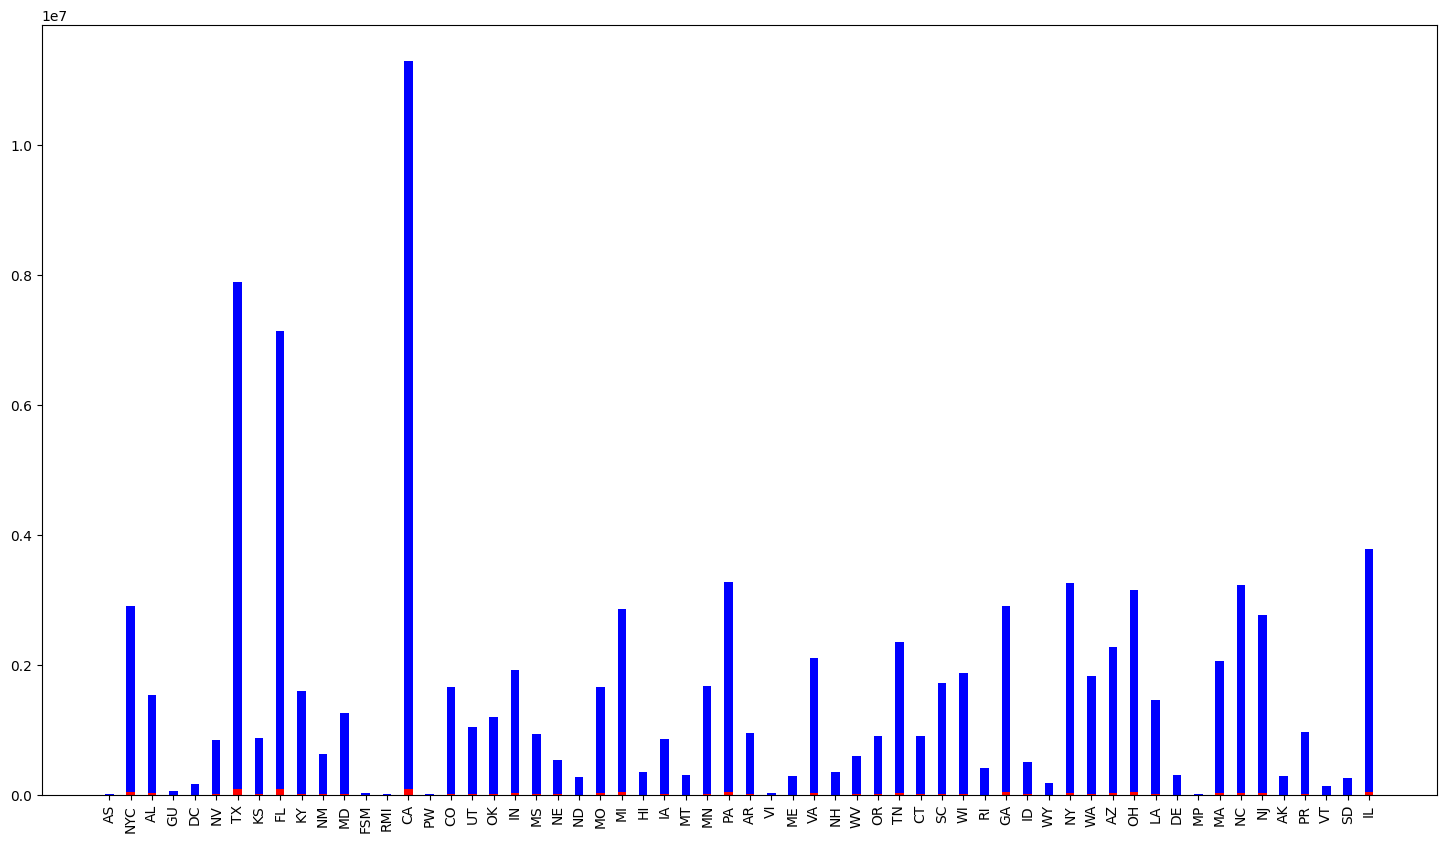

In [ ]:
from turtle import color


df_cases.head()
# create data
plt.figure(figsize=(18,10))
x = df_cases['state']
y1 = df_cases['tot_cases']
y2 = df_cases['tot_death']
width = 0.40
  
# plot data in grouped manner of bar type
plt.bar(x, y1, width, color='b')
plt.bar(x, y2, width, color='r')
plt.xticks(rotation=90);


In [ ]:
df_cases.groupby(by='state').sum().T

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
tot_cases,103800015,638327202,403775153,1382283,978893192,4364733842,658900625,367082955,64506024,123511033,...,985632802,3307212352,451582481,800947192,7188849,42676851,644705150,775370683,219275324,74375640
new_case,282632,1528319,954552,8250,2275235,11107087,1660829,888009,168122,310527,...,2327351,7691340,1040147,2099126,23103,133252,1825126,1875895,603256,177635
tot_death,533125,10915844,5830937,5776,15992140,50457009,6600246,7159317,929885,1674285,...,12689455,47538683,2350692,10365763,52258,288765,6442064,7409068,3159079,845670
new_death,1186,20498,12041,34,31644,95414,13348,11385,1383,3094,...,25437,89344,5018,21986,123,698,14417,15321,7387,1904


In [ ]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [ ]:
df_cases.groupby(by='state').sum().shape

(60, 4)

In [ ]:
df_fips = pd.read_csv('../data/states_fips.csv')
df_fips.head(50)

,name,postal_code,fips
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,District of Columbia,DC,11
9,Florida,FL,12


In [ ]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_state

['AK',
 'AL',
 'AR',
 'AS',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'FSM',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MP',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'NYC',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'PW',
 'RI',
 'RMI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [ ]:
list_fips = list(df_fips['postal_code'])
list_fips

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY',
 'AS',
 'GU',
 'MP',
 'PR',
 'VI']

In [ ]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [ ]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

In [ ]:
df_us = df_cases.groupby(by='state').sum()
df_us.shape

(60, 4)

In [ ]:
df_us.loc['FSM']

tot_cases    753724
new_case      22005
tot_death      1997
new_death        51
Name: FSM, dtype: int64

In [ ]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_us.drop(index=not_state_list,inplace=True)
df_us.shape

(52, 4)

In [ ]:
df_us.sort_index()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383
DE,123511033,310527,1674285,3094


In [ ]:
#!pip install plotly-geo=="1.0.0"
#!pip install geopandas==0.3.0
#!pip install pyshp==1.2.10
#!pip install shapely==1.6.3

In [ ]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(
    data = go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = df['total exports'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [ ]:
fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))

fig = ft.create_choropleth(fips=fips, values=values)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

## EDA - COVID Deaths in US
____

In [ ]:
df_deaths.info()

In [ ]:
df_deaths = df_deaths.groupby(by=df_deaths.index).sum()
df_deaths.head()

In [ ]:
df_deaths.drop(columns=['tot_cases','tot_death','new_case'], inplace=True)


In [ ]:
df_deaths.sort_values(by='new_death', ascending=True)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df_deaths['new_death']);

# Vacination data
____


In [ ]:
df_vacc=pd.read_csv('../data/covid_vaccination_trends.csv', low_memory=False)
df_vacc.info()

In [ ]:
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)


In [ ]:
df_vacc.columns

In [ ]:
df_vacc.drop(columns=['date_type','MMWR_week'],inplace=True)
df_vacc

In [ ]:
df_vacc.drop(columns=['Administered_Daily', 'Administered_Cumulative',
       'Administered_7_Day_Rolling_Average', 'Admin_Dose_1_Daily', 'Admin_Dose_1_Day_Rolling_Average',
       'Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],inplace=True)


In [ ]:
df_vacc.info()

In [ ]:
df_vacc['Admin_Dose_1_Cumulative'] = df_vacc['Admin_Dose_1_Cumulative'].map( lambda x: x.replace(',','')).astype(int)
df_vacc.info()

In [ ]:
df_vacc = df_vacc.groupby(by=df_vacc.index).sum()
df_vacc.head()

In [ ]:
df_vacc.head(70)